In [1]:
'''
This notebook tells us how much the autoencoder compressed reprentation can be further 
compressed using a standard compression algrithm like gzip.
Our hypothesis was that the standard compression algorithm should achieve a similar compression factor no matter the 
encoding dimension, which was confirmed.
A similar analysis should be repeated for zero padding algorithms, where we expect 
small deviations (~ one more decimal point required).
'''

'\nThis notebook tells us how much the autoencoder compressed reprentation can be further \ncompressed using a standard compression algrithm like gzip.\nOur hypothesis was that the standard compression algorithm should achieve a similar compression factor no matter the \nencoding dimension, which was confirmed.\nA similar analysis should be repeated for zero padding algorithms, where we expect \nsmall deviations (~ one more decimal point required).\n'

In [2]:
import pickle
import ROOT
from ROOT import TFile, TTree
from array import array
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
#plt.rc('text', usetex=True)
from __future__ import print_function

Welcome to JupyROOT 6.12/04


In [3]:
TYPE = "" # 100% of the data. To determine the real performance of the cross check
#TYPE = "_10perc" #10% of the data. Used for everything except to determine the real performance of the cross check
#TYPE = "_1perc" #1% of the data. For small tests.
#TYPE = "_100" #100 samples of the data. For very rudimentary tests

#TO GET ACTUAL RESULTS RUN THIS WITH 10% or 100% of the data



retain_dict = pickle.load( open( "retain_dict_{}.p".format(TYPE), "rb" ) )
all_input = retain_dict.pop("test_input")
all_encoded_dict = retain_dict.pop("save_encoded_dict")


In [4]:
l_encoding_dim = [1,3,5,8,11,14,18]
#l_encoding_dim = [0, 1, 8, 18]
l_encoding_dim = [1,3,6,9,12,15,18]

d_FS = {}

for encoding_dim in l_encoding_dim:
    d_FS[encoding_dim] = {}
    for HALF in [ True, False]:
        if encoding_dim==18:
            encoding_dim_name = "Uncompressed"
            data = all_input

        else:
            encoding_dim_name = "Compressed{}".format(encoding_dim)
            data = all_encoded_dict[encoding_dim]
        
        if HALF: data = data[:(data.shape[0]/2), :]

        if HALF: encoding_dim_name += "_Half"
            
        filename = '{}_{}.root'.format(encoding_dim_name, TYPE)
        #print data
        vars_list_input = range(data.shape[1])


        f = TFile(filename , 'recreate' )
        t = TTree( 'data', 'tree with info' )

        d_dict = {}
        for var in vars_list_input:
            d_dict[var] = array( 'f', [ 0. ] )
            t.Branch( "".format(var), d_dict[var], '{}/F'.format(var) )

        for i in range(data.shape[0]):
            for var_i, var in enumerate(vars_list_input):
                d_dict[var] = data[i][var_i]
            t.Fill()
            
        f.Write()
        f.Close()


        d_FS[encoding_dim][HALF] = os.path.getsize(filename)
        #maxn = 10
        #n = array( 'i', [ 0 ] )
        #d = array( 'f', maxn*[ 0. ] )
        #t.Branch( 'mynum', n, 'mynum/I' )
        #t.Branch( 'myval', d, 'myval[mynum]/F' )
        #for i in range(25):
        #   n[0] = min(i,maxn)
        #   for j in range(n[0]):
        #      d[j] = i*0.1+j
        #   t.Fill()

        

In [5]:
d_FS

{1: {False: 13313, True: 9596},
 3: {False: 29185, True: 17335},
 6: {False: 54587, True: 29399},
 9: {False: 79601, True: 42748},
 12: {False: 105529, True: 55239},
 15: {False: 130278, True: 67957},
 18: {False: 155276, True: 79745}}

In [6]:
l_FS = []
for encoding_dim in l_encoding_dim:
    l_FS.append(2*(d_FS[encoding_dim][False]-d_FS[encoding_dim][True])/1000.)


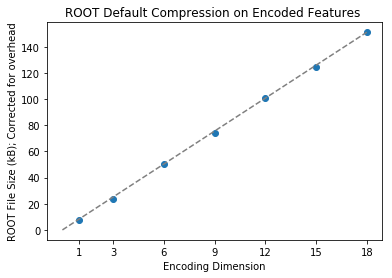

In [7]:
plt.plot(l_encoding_dim, l_FS , '.', markersize=12)
plt.xlabel("Encoding Dimension")
plt.xticks(l_encoding_dim)
plt.ylabel('ROOT File Size (kB); Corrected for overhead')
plt.plot([0, l_encoding_dim[-1]], [0,l_FS[-1]], color='grey', linestyle='--')
#plt.ylabel('ROOT File Size (kB) \n Corrected for overhead')
plt.title("ROOT Default Compression on Encoded Features ")
plt.savefig("ROOT_Default_compression_{}.png".format(TYPE))

In [8]:
# If everything went right, the blue dots should follow the grey line pretty well. 
# This indicates that the standard compression algorithm should achieve a similar 
# compression factor no matter the encoding dimension.